# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import scipy as sp
import numpy as np
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import wandb

sys.path.append('../../../')

device = "cuda" if torch.cuda.is_available() else "cpu"

## Build Model

In [2]:
from LightningModules.GNN.gnn_base import GNNBase
from LightningModules.GNN.utils import make_mlp, load_dataset
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch_scatter import scatter_add, scatter_mean, scatter_max

from sklearn.metrics import roc_auc_score

class DenoiserBase(GNNBase):
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """
        
    def setup(self, stage):
        # Handle any subset of [train, val, test] data split, assuming that ordering
                
        if self.trainset is None:
            print("Setting up dataset")
            input_dirs = [None, None, None]
            input_dirs[: len(self.hparams["datatype_names"])] = [
                os.path.join(self.hparams["input_dir"], datatype)
                for datatype in self.hparams["datatype_names"]
            ]
            self.trainset, self.valset, self.testset = [
                load_dataset(
                    input_dir, 
                    self.hparams["datatype_split"][i], 
                    self.hparams["pt_background_min"],
                    self.hparams["pt_signal_min"],
                    self.hparams["noise"]
                )
                for i, input_dir in enumerate(input_dirs)
            ]
        
        if (self.trainer) and ("logger" in self.trainer.__dict__.keys()) and ("_experiment" in self.logger.__dict__.keys()):
            self.logger.experiment.define_metric("val_loss" , summary="min")
            self.logger.experiment.define_metric("auc" , summary="max")
    
    def get_metrics(self, truth, output):
        
        prediction = torch.sigmoid(output)
        positive = prediction > self.hparams["cut"]
        
        tp = (positive & truth.bool()).sum().item()     
        
        eff = tp / truth.sum()
        pur = tp / positive.sum()
        
        try:
#             print("Getting auc")
            auc = roc_auc_score(truth.bool().cpu().detach(), prediction.cpu().detach())
        except:
#             print("AUC error")
            auc = 0
                
#         print("TP:", tp, "True:", truth.sum())
        return prediction, eff, pur, auc
    
    def handle_directed(self, batch, edge_sample):
        
        edge_sample = torch.cat([edge_sample, edge_sample.flip(0)], dim=-1)
        
        if ("directed" in self.hparams.keys()) and self.hparams["directed"]:
            direction_mask = batch.x[edge_sample[0], 0] < batch.x[edge_sample[1], 0]
            edge_sample = edge_sample[:, direction_mask]
            truth_sample = truth_sample[direction_mask]
        
        return edge_sample
    
    def training_step(self, batch, batch_idx):

        """
        Args:
            batch (``list``, required): A list of ``torch.tensor`` objects
            batch (``int``, required): The index of the batch

        Returns:
            ``torch.tensor`` The loss function as a tensor
        """

        # Forward pass of model, handling whether Cell Information (ci) is included
        edge_sample = self.handle_directed(batch, batch.edge_index)
        input_data = self.get_input_data(batch)
        output = self(input_data, edge_sample).squeeze()
        
        truth = (batch.pid == 0)

        loss = F.binary_cross_entropy_with_logits(output, truth.float())
        
        prediction, eff, pur, auc = self.get_metrics(truth, output)
        
        self.log_dict({"train_loss": loss}, on_step=False, on_epoch=True)
        
        return loss

    def shared_evaluation(self, batch, batch_idx, log=True):

        # Forward pass of model, handling whether Cell Information (ci) is included
        edge_sample = self.handle_directed(batch, batch.edge_index)
        input_data = self.get_input_data(batch)
        output = self(input_data, edge_sample).squeeze()
        
        truth = (batch.pid == 0)
        
        loss = F.binary_cross_entropy_with_logits(output,  truth.float())

        prediction, eff, pur, auc = self.get_metrics(truth, output)
        
        current_lr = self.optimizers().param_groups[0]["lr"]
        
        if log:
            self.log_dict({"val_loss": loss, "eff": eff, "pur": pur, "auc": auc, "current_lr": current_lr}, on_step=False, on_epoch=True)
        
        return {
            "loss": loss,
            "preds": prediction,
            "eff": eff, 
            "pur": pur,
            "auc": auc
        }

class Denoiser(DenoiserBase):
    
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different GNN training regimes
        """
        
        concatenation_factor = 3 if (self.hparams["aggregation"] in ["sum_max", "mean_max"]) else 2

        # Setup input network
        self.node_encoder = make_mlp(
            hparams["spatial_channels"] + hparams["cell_channels"],
            [hparams["hidden"]] * hparams["nb_node_layer"],
            output_activation=None,
            hidden_activation=hparams["hidden_activation"],
            layer_norm=hparams["layernorm"],
        )

        # The edge network computes new edge features from connected nodes
        self.edge_encoder = make_mlp(
            2 * (hparams["hidden"]),
            [hparams["hidden"]] * hparams["nb_edge_layer"],
            layer_norm=hparams["layernorm"],
            output_activation=None,
            hidden_activation=hparams["hidden_activation"],
        )

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(
            3 * hparams["hidden"],
            [hparams["hidden"]] * hparams["nb_edge_layer"],
            layer_norm=hparams["layernorm"],
            output_activation=None,
            hidden_activation=hparams["hidden_activation"],
        )

        # The node network computes new node features
        self.node_network = make_mlp(
            concatenation_factor * hparams["hidden"],
            [hparams["hidden"]] * hparams["nb_node_layer"],
            layer_norm=hparams["layernorm"],
            output_activation=None,
            hidden_activation=hparams["hidden_activation"],
        )

        # Final edge output classification network
        self.output_node_classifier = make_mlp(
            hparams["hidden"],
            [hparams["hidden"]]* hparams["nb_node_layer"] + [1],
            layer_norm=hparams["layernorm"],
            output_activation=None,
            hidden_activation=hparams["hidden_activation"],
        )

    def message_step(self, x, start, end, e):
        
        # Compute new node features        
        if self.hparams["aggregation"] == "sum":  
            edge_messages = scatter_add(e, end, dim=0, dim_size=x.shape[0]) 
        
        elif self.hparams["aggregation"] == "max":
            edge_messages = scatter_max(e, end, dim=0, dim_size=x.shape[0])[0]

        elif self.hparams["aggregation"] == "sum_max":
            edge_messages = torch.cat([scatter_max(e, end, dim=0, dim_size=x.shape[0])[0],
                                 scatter_add(e, end, dim=0, dim_size=x.shape[0])], dim=-1)
        node_inputs = torch.cat([x, edge_messages], dim=-1)
        
        x_out = self.node_network(node_inputs)
        
        x_out += x

        # Compute new edge features
        edge_inputs = torch.cat([x[start], x[end], e], dim=-1)
        e_out = self.edge_network(edge_inputs)   
        
        e_out += e
        
        return x_out, e_out
        
    def output_step(self, x):
        
        return self.output_node_classifier(x)
    
    def forward(self, x, edge_index):

        start, end = edge_index

        # Encode the graph features into the hidden space
        x.requires_grad = True
        x = checkpoint(self.node_encoder, x)
        e = checkpoint(self.edge_encoder, torch.cat([x[start], x[end]], dim=1))

        #         edge_outputs = []
        # Loop over iterations of edge and node networks
        for i in range(self.hparams["n_graph_iters"]):

            x, e = checkpoint(self.message_step, x, start, end, e)
        
        # Compute final edge scores; use original edge directions only        
        return checkpoint(self.output_step, x)

## Pytorch Lightning Model

In [3]:
with open("example_denoising.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [4]:
model = Denoiser(hparams)

## The Dataset

In [14]:
%%time
model.setup(stage="fit")

Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
CPU times: user 449 ms, sys: 1.99 s, total: 2.44 s
Wall time: 10.2 s


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [6]:
trainset = model.trainset

In [7]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [8]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

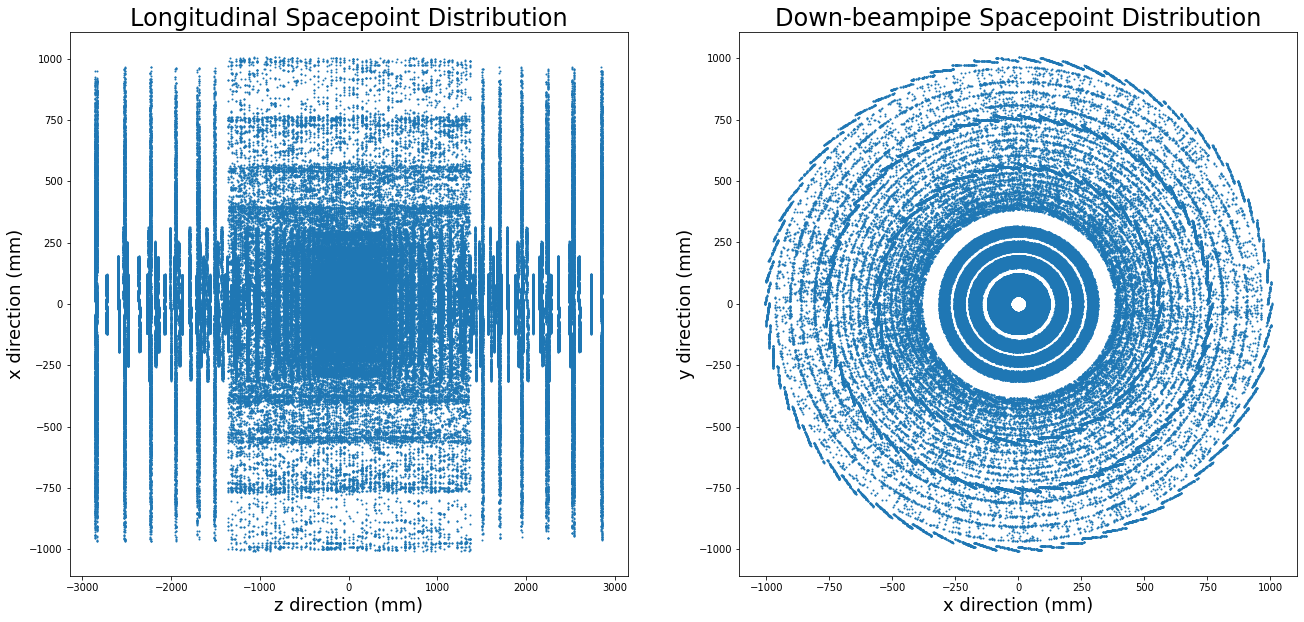

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

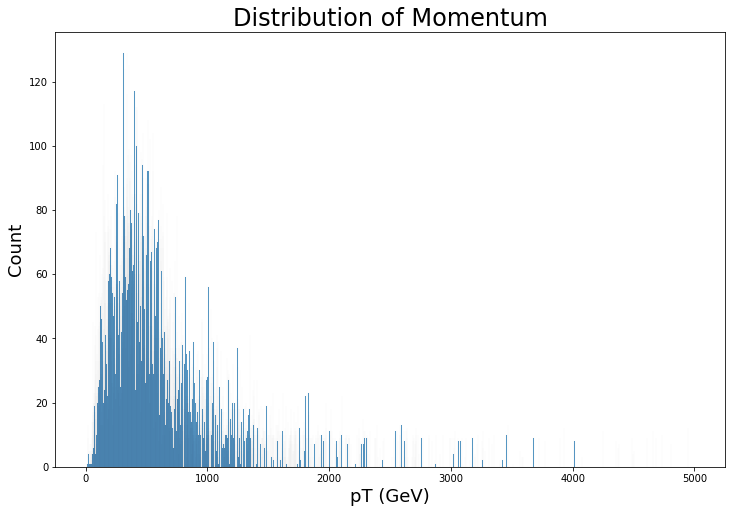

In [45]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.pt == example_data.pt], binwidth=500, binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

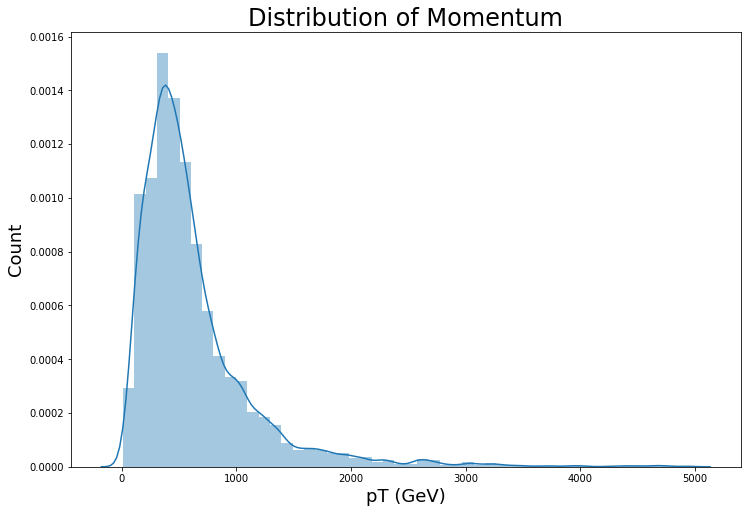

In [46]:
plt.figure(figsize=(12,8))
sns.distplot(example_data.pt[(example_data.pt == example_data.pt) & (example_data.pt < 5000)])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [47]:
particle_count_list = [np.unique(sample.pid.numpy(), return_counts = True)[1][1:] for sample in trainset]

In [48]:
particle_counts = np.concatenate(particle_count_list)

In [49]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

Number of particles: 8130


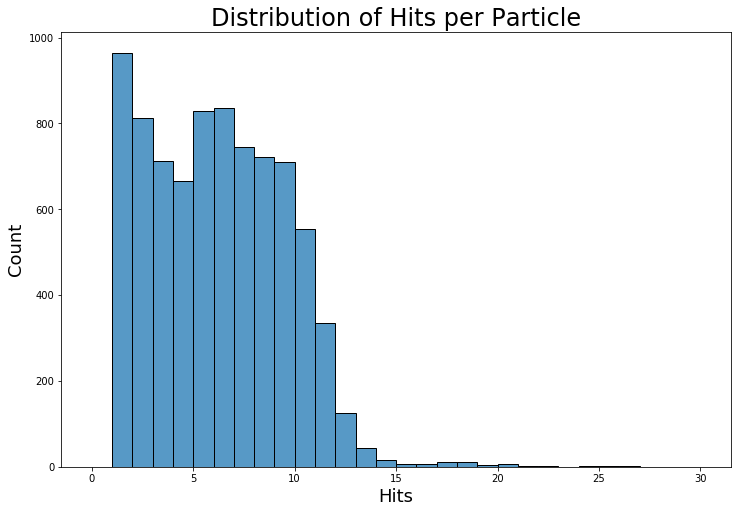

In [50]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[1:], binwidth=1, binrange=[0, 30])
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)
print("Number of particles:", len(particle_num))

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Cell Info

In [20]:
cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
            "pixel"
        ]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

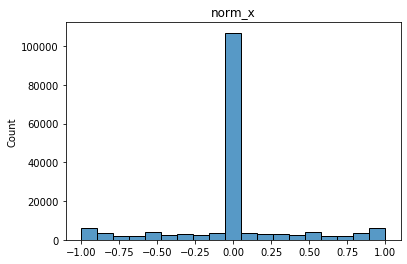

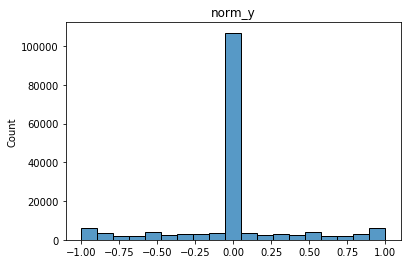

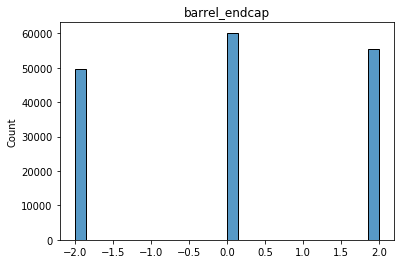

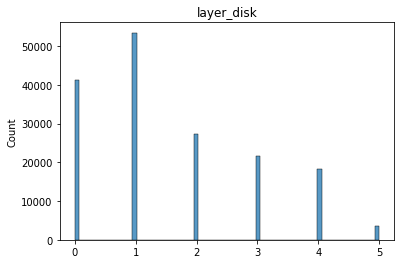

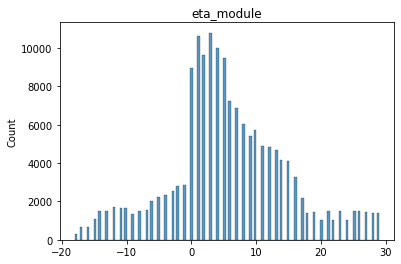

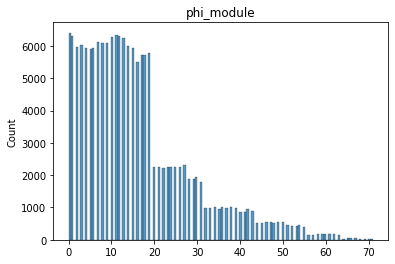

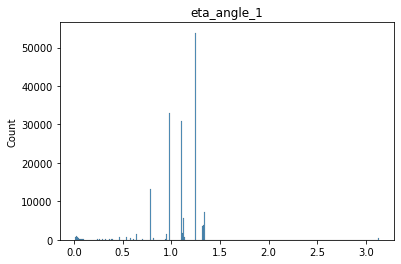

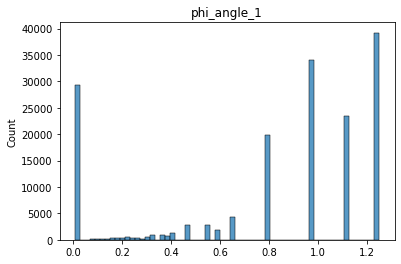

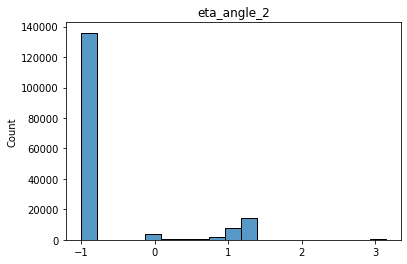

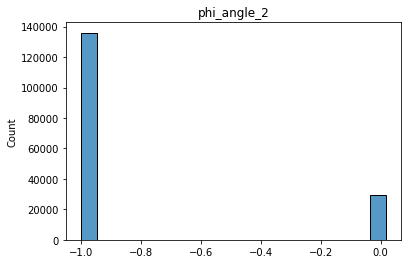

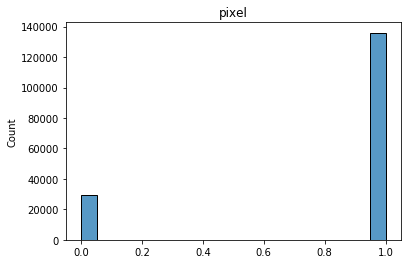

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Noise Classification

### Train classifier

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='auc',
    mode="max",
    save_top_k=2,
    save_last=True)

In [ ]:
logger = WandbLogger(project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"])
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=logger, callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Events loaded!
Events processed!


wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 35.5 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_node_classifier | Sequential | 50.4 K
------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.272     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


/global/homes/d/danieltm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  95%|█████████▌| 1000/1050 [18:32<00:55,  1.11s/it, loss=0.534, v_num=s1f6]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/50 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  95%|█████████▌| 1002/1050 [18:33<00:53,  1.11s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  96%|█████████▌| 1004/1050 [18:33<00:51,  1.11s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  96%|█████████▌| 1006/1050 [18:34<00:48,  1.11s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  12%|█▏        | 6/50 [00:01<00:10,  4.28it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  16%|█▌        | 8/50 [00:01<00:09,  4.33it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  96%|█████████▌| 1010/1050 [18:35<00:44,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  20%|██        | 10/50 [00:02<00:09,  4.19it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  96%|█████████▋| 1012/1050 [18:35<00:41,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  24%|██▍       | 12/50 [00:02<00:09,  4.00it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  97%|█████████▋| 1014/1050 [18:36<00:39,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  28%|██▊       | 14/50 [00:03<00:08,  4.04it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  97%|█████████▋| 1016/1050 [18:36<00:37,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  32%|███▏      | 16/50 [00:03<00:08,  3.80it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  97%|█████████▋| 1018/1050 [18:37<00:35,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  36%|███▌      | 18/50 [00:04<00:09,  3.39it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  97%|█████████▋| 1020/1050 [18:37<00:32,  1.10s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  40%|████      | 20/50 [00:05<00:09,  3.32it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  97%|█████████▋| 1022/1050 [18:38<00:30,  1.09s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  44%|████▍     | 22/50 [00:05<00:08,  3.47it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  98%|█████████▊| 1024/1050 [18:38<00:28,  1.09s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  48%|████▊     | 24/50 [00:06<00:06,  3.72it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  98%|█████████▊| 1026/1050 [18:39<00:26,  1.09s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  52%|█████▏    | 26/50 [00:06<00:06,  3.87it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  98%|█████████▊| 1028/1050 [18:39<00:23,  1.09s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  56%|█████▌    | 28/50 [00:07<00:06,  3.60it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  60%|██████    | 30/50 [00:07<00:05,  3.83it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  98%|█████████▊| 1032/1050 [18:41<00:19,  1.09s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  64%|██████▍   | 32/50 [00:08<00:04,  3.78it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  98%|█████████▊| 1034/1050 [18:41<00:17,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  68%|██████▊   | 34/50 [00:08<00:04,  3.64it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  72%|███████▏  | 36/50 [00:09<00:03,  3.94it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  99%|█████████▉| 1038/1050 [18:42<00:12,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  76%|███████▌  | 38/50 [00:10<00:03,  3.85it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  99%|█████████▉| 1040/1050 [18:43<00:10,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  80%|████████  | 40/50 [00:10<00:02,  3.66it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  99%|█████████▉| 1042/1050 [18:43<00:08,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  84%|████████▍ | 42/50 [00:11<00:02,  3.61it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0:  99%|█████████▉| 1044/1050 [18:44<00:06,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  88%|████████▊ | 44/50 [00:11<00:01,  3.83it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0: 100%|█████████▉| 1046/1050 [18:44<00:04,  1.08s/it, loss=0.534, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  92%|█████████▏| 46/50 [00:12<00:00,  4.05it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  96%|█████████▌| 48/50 [00:12<00:00,  4.22it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 0: 100%|██████████| 1050/1050 [18:45<00:00,  1.07s/it, loss=0.534, v_num=s1f6]
                                                           

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1:  95%|█████████▌| 1000/1050 [18:34<00:55,  1.11s/it, loss=0.525, v_num=s1f6]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/50 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  95%|█████████▌| 1002/1050 [18:35<00:53,  1.11s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  96%|█████████▌| 1004/1050 [18:35<00:51,  1.11s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  96%|█████████▌| 1006/1050 [18:36<00:48,  1.11s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  12%|█▏        | 6/50 [00:01<00:10,  4.28it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  16%|█▌        | 8/50 [00:01<00:09,  4.29it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  96%|█████████▌| 1010/1050 [18:37<00:44,  1.11s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  20%|██        | 10/50 [00:02<00:09,  4.15it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  96%|█████████▋| 1012/1050 [18:37<00:41,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  24%|██▍       | 12/50 [00:02<00:09,  3.96it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  97%|█████████▋| 1014/1050 [18:38<00:39,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  28%|██▊       | 14/50 [00:03<00:08,  4.01it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  97%|█████████▋| 1016/1050 [18:38<00:37,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  32%|███▏      | 16/50 [00:03<00:08,  3.79it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  97%|█████████▋| 1018/1050 [18:39<00:35,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  36%|███▌      | 18/50 [00:04<00:09,  3.37it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  97%|█████████▋| 1020/1050 [18:39<00:32,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  40%|████      | 20/50 [00:05<00:09,  3.30it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  97%|█████████▋| 1022/1050 [18:40<00:30,  1.10s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  44%|████▍     | 22/50 [00:05<00:08,  3.44it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  98%|█████████▊| 1024/1050 [18:40<00:28,  1.09s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  48%|████▊     | 24/50 [00:06<00:07,  3.70it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  98%|█████████▊| 1026/1050 [18:41<00:26,  1.09s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  52%|█████▏    | 26/50 [00:06<00:06,  3.85it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  98%|█████████▊| 1028/1050 [18:41<00:24,  1.09s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  56%|█████▌    | 28/50 [00:07<00:06,  3.58it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  60%|██████    | 30/50 [00:07<00:05,  3.81it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  98%|█████████▊| 1032/1050 [18:43<00:19,  1.09s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  64%|██████▍   | 32/50 [00:08<00:04,  3.77it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  98%|█████████▊| 1034/1050 [18:43<00:17,  1.09s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  68%|██████▊   | 34/50 [00:09<00:04,  3.63it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  72%|███████▏  | 36/50 [00:09<00:03,  3.93it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  99%|█████████▉| 1038/1050 [18:44<00:13,  1.08s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  76%|███████▌  | 38/50 [00:10<00:03,  3.83it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  99%|█████████▉| 1040/1050 [18:45<00:10,  1.08s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  80%|████████  | 40/50 [00:10<00:02,  3.63it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  99%|█████████▉| 1042/1050 [18:45<00:08,  1.08s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  84%|████████▍ | 42/50 [00:11<00:02,  3.59it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1:  99%|█████████▉| 1044/1050 [18:46<00:06,  1.08s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  88%|████████▊ | 44/50 [00:11<00:01,  3.84it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1: 100%|█████████▉| 1046/1050 [18:46<00:04,  1.08s/it, loss=0.525, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  92%|█████████▏| 46/50 [00:12<00:00,  4.07it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  96%|█████████▌| 48/50 [00:12<00:00,  4.22it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 1: 100%|██████████| 1050/1050 [18:47<00:00,  1.07s/it, loss=0.525, v_num=s1f6]
                                                           

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 2:  47%|████▋     | 498/1050 [09:15<10:15,  1.12s/it, loss=0.511, v_num=s1f6] 

wandb: Network error (ConnectionError), entering retry loop.


Epoch 2:  95%|█████████▌| 1000/1050 [18:33<00:55,  1.11s/it, loss=0.513, v_num=s1f6]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/50 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  95%|█████████▌| 1002/1050 [18:34<00:53,  1.11s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  96%|█████████▌| 1004/1050 [18:34<00:51,  1.11s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  96%|█████████▌| 1006/1050 [18:35<00:48,  1.11s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  12%|█▏        | 6/50 [00:01<00:10,  4.29it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  16%|█▌        | 8/50 [00:01<00:09,  4.32it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  96%|█████████▌| 1010/1050 [18:36<00:44,  1.11s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  20%|██        | 10/50 [00:02<00:09,  4.20it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  96%|█████████▋| 1012/1050 [18:36<00:41,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  24%|██▍       | 12/50 [00:02<00:09,  4.01it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  97%|█████████▋| 1014/1050 [18:37<00:39,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  28%|██▊       | 14/50 [00:03<00:08,  4.06it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  97%|█████████▋| 1016/1050 [18:37<00:37,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  32%|███▏      | 16/50 [00:03<00:08,  3.83it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  97%|█████████▋| 1018/1050 [18:38<00:35,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  36%|███▌      | 18/50 [00:04<00:09,  3.41it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  97%|█████████▋| 1020/1050 [18:38<00:32,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  40%|████      | 20/50 [00:05<00:09,  3.31it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  97%|█████████▋| 1022/1050 [18:39<00:30,  1.10s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  44%|████▍     | 22/50 [00:05<00:08,  3.45it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  98%|█████████▊| 1024/1050 [18:39<00:28,  1.09s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  48%|████▊     | 24/50 [00:06<00:07,  3.70it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  98%|█████████▊| 1026/1050 [18:40<00:26,  1.09s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  52%|█████▏    | 26/50 [00:06<00:06,  3.87it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  98%|█████████▊| 1028/1050 [18:40<00:23,  1.09s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  56%|█████▌    | 28/50 [00:07<00:06,  3.59it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  60%|██████    | 30/50 [00:07<00:05,  3.82it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  98%|█████████▊| 1032/1050 [18:42<00:19,  1.09s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  64%|██████▍   | 32/50 [00:08<00:04,  3.79it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  98%|█████████▊| 1034/1050 [18:42<00:17,  1.09s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  68%|██████▊   | 34/50 [00:08<00:04,  3.64it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  72%|███████▏  | 36/50 [00:09<00:03,  3.95it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  99%|█████████▉| 1038/1050 [18:43<00:12,  1.08s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  76%|███████▌  | 38/50 [00:09<00:03,  3.84it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  99%|█████████▉| 1040/1050 [18:44<00:10,  1.08s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  80%|████████  | 40/50 [00:10<00:02,  3.65it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  99%|█████████▉| 1042/1050 [18:44<00:08,  1.08s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  84%|████████▍ | 42/50 [00:11<00:02,  3.61it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2:  99%|█████████▉| 1044/1050 [18:45<00:06,  1.08s/it, loss=0.513, v_num=s1f6]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  88%|████████▊ | 44/50 [00:11<00:01,  3.83it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  92%|█████████▏| 46/50 [00:12<00:00,  4.08it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Validating:  96%|█████████▌| 48/50 [00:12<00:00,  4.24it/s]

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



Epoch 2: 100%|██████████| 1050/1050 [18:46<00:00,  1.07s/it, loss=0.513, v_num=s1f6]
                                                           

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 3:  24%|██▍       | 254/1050 [04:45<14:55,  1.13s/it, loss=0.516, v_num=s1f6] 

In [9]:
model = model.to(device)

In [7]:
model.valset[0].to(device)

Data(cell_data=[104365, 11], edge_index=[2, 310705], event_file="/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010005", hid=[104365], modulewise_true_edges=[2, 41921], nhits=[104365], pid=[104365], primary=[104365], pt=[104365], signal_true_edges=[2, 5955], x=[104365, 3], y=[310705], y_pid=[310705])

In [23]:
with torch.no_grad():
    model.hparams["cut"] = 0.6
    result = model.shared_evaluation(model.valset[0].to(device), 0, log=False)

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [25]:
result

{'loss': tensor(0.4994, device='cuda:0'),
 'preds': tensor([0.1385, 0.1885, 0.0692,  ..., 0.1632, 0.7745, 0.7924], device='cuda:0'),
 'eff': tensor(0.7072, device='cuda:0'),
 'pur': tensor(0.7897, device='cuda:0'),
 'auc': 0.8363670544753555}

In [26]:
(model.valset[0].pid == 0).sum()

tensor(53451, device='cuda:0')

In [36]:
(model.valset[0].pid != 0).sum()

tensor(50914, device='cuda:0')

In [41]:
model.valset[0].edge_index.shape

torch.Size([2, 310705])

In [37]:
(result["preds"] > 0.6)[model.valset[0].signal_true_edges].all(0).sum()

tensor(288, device='cuda:0')

In [53]:
(result["preds"] > 0.5)[model.valset[0].edge_index].all(0).sum()

tensor(81250, device='cuda:0')

In [54]:
(result["preds"] > 0.5)[model.valset[0].edge_index[:, model.valset[0].y.bool()]].all(0).sum()

tensor(445, device='cuda:0')

In [55]:
(result["preds"] > 0.5)[model.valset[0].edge_index[:, model.valset[0].y_pid.bool()]].all(0).sum()

tensor(48261, device='cuda:0')

In [48]:
model.valset[0].y.bool().sum()

tensor(5623, device='cuda:0')

In [33]:
(result["preds"] > 0.6)[model.valset[0].signal_true_edges].shape

torch.Size([2, 5955])

In [40]:
pred_X = model.valset[0].x[(result["preds"] > 0.8)]

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


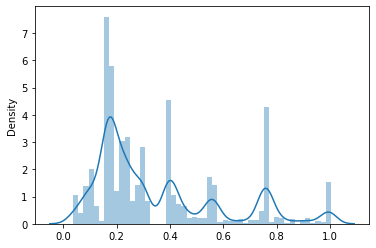

In [42]:
sns.distplot(pred_X[:, 0].cpu())

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/

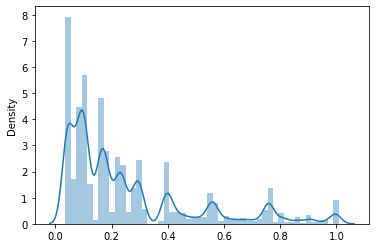

In [44]:
sns.distplot(model.valset[0].x[:, 0].cpu())

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/

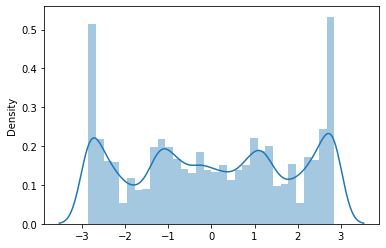

In [43]:
sns.distplot(pred_X[:, 2].cpu())

### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [ ]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

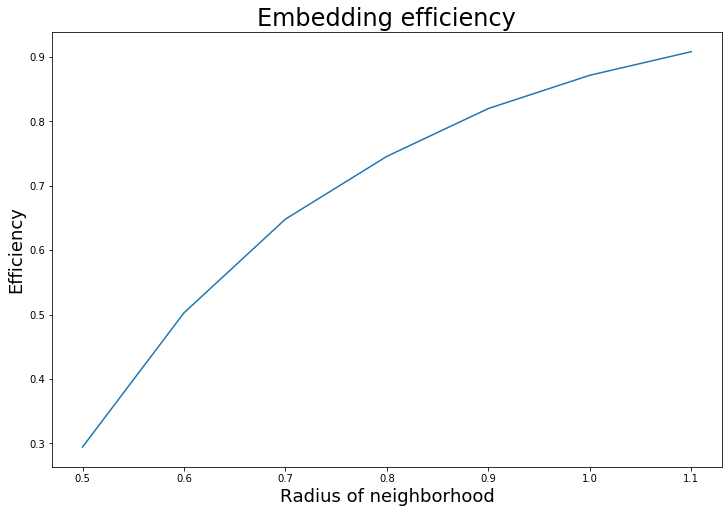

In [28]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);

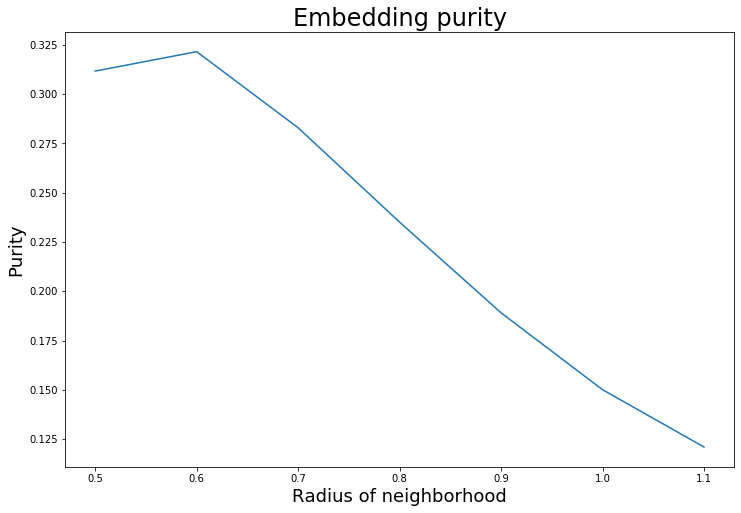

In [29]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

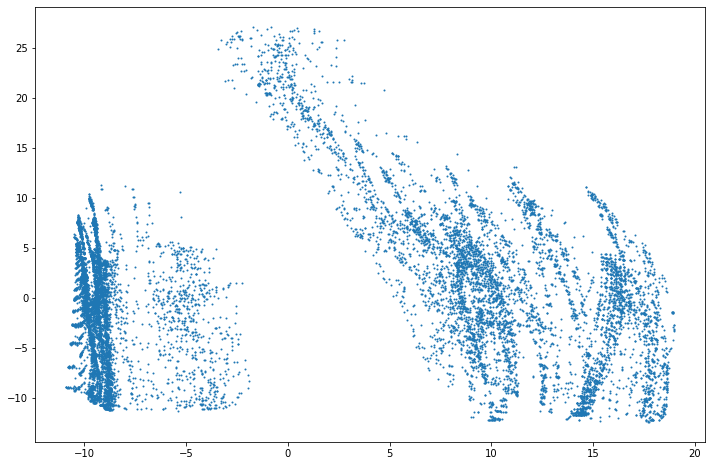

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

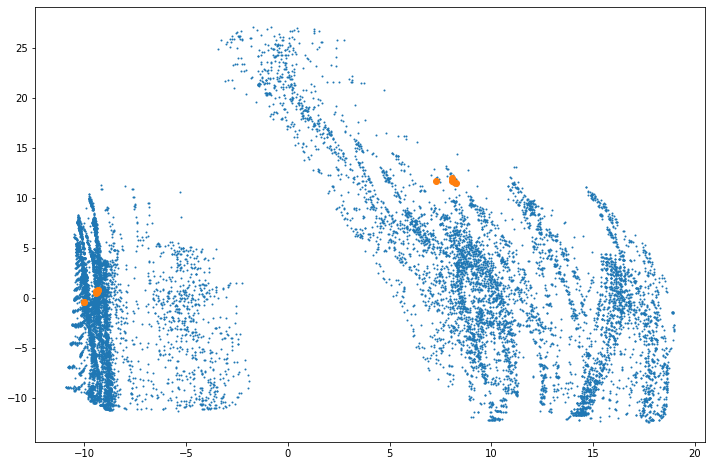

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(reduced_dimensions[particle_ids == example_particle, 0], reduced_dimensions[particle_ids == example_particle, 1])

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

### Distributions

In [7]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [6]:
def get_performance(model, batch, r_max, k_max):
    with torch.no_grad():
        results = model.shared_evaluation(batch, 0, r_max, k_max)
    
    return results["truth"], results["preds"], results["truth_graph"]

In [7]:
r_max = 0.4
k_max = 2000

In [8]:
%%time
batch = 0
model.eval()

y_cluster, e_spatial, e_bidir = get_performance(model, model.testset[batch].to(device), r_max=r_max, k_max=k_max)

Average nbhood: 54.47683273347225
CPU times: user 575 ms, sys: 5.27 ms, total: 580 ms
Wall time: 96.7 ms


/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:279: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)


In [9]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025037623941898346, Eff: 0.9926109910011292


In [44]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025036856532096863, Eff: 0.9926661252975464


In [45]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025036856532096863, Eff: 0.9926661252975464


In [12]:
eta_cuts = np.arange(-4, 4.5, 0.5)
batch_range = np.arange(0,200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in batch_range[:5]:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=r_max, k_max=k_max)
    
    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[e_spatial[0]] + eta_hits[e_spatial[1]])/2
    av_eta_true = (eta_hits[e_bidir[0]] + eta_hits[e_bidir[1]])/2
    
    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_true = (av_eta_true >= eta1) & (av_eta_true <= eta2)
        true_positives = y_cluster[edge_eta_pred]

        eta_eff_list.append(true_positives.sum().item() / edge_eta_true.sum().item())
        eta_pur_list.append(true_positives.sum().item() / true_positives.shape[0])

RuntimeError: CUDA out of memory. Tried to allocate 1.52 GiB (GPU 0; 15.78 GiB total capacity; 11.62 GiB already allocated; 1.49 GiB free; 12.93 GiB reserved in total by PyTorch)

In [ ]:
eta_eff_reshape = np.array(eta_eff_list).reshape(eta_cuts.shape[0]-1, len(batch_range))
eta_pur_reshape = np.array(eta_pur_list).reshape(eta_cuts.shape[0]-1, len(batch_range))

Train set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

Test set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_eff_reshape.mean(1), eta_eff_reshape.std(1), fmt="o")

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_pur_reshape.mean(1), eta_pur_reshape.std(1), fmt="o")

In [ ]:
pt_cuts = np.arange(900, 5000, 500)

pt_eff_list = []
pt_pur_list = []
    
for batch_idx in batch_range:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=1.2, k_max=500)
    
    av_pt_preds = (batch.pt[e_spatial[0]] + batch.pt[e_spatial[1]])/2
    av_pt_true = (batch.pt[e_bidir[0]] + batch.pt[e_bidir[1]])/2
    
    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        true_positives = y_cluster[edge_pt_pred]

        pt_eff_list.append(true_positives.sum().item() / max(1, edge_pt_true.sum().item()))
        pt_pur_list.append(true_positives.sum().item() / max(1, true_positives.shape[0]))
    

In [ ]:
pt_eff_reshape = np.array(pt_eff_list).reshape(pt_cuts.shape[0]-1, len(batch_range))
pt_pur_reshape = np.array(pt_pur_list).reshape(pt_cuts.shape[0]-1, len(batch_range))

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_eff_reshape.mean(1), pt_eff_reshape.std(1), fmt="o")

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_pur_reshape.mean(1), pt_pur_reshape.std(1), fmt="o")

## Memory of Edge Builder

In [29]:
torch.cuda.max_memory_allocated() / 1024**3

4.934445381164551

In [26]:
torch.cuda.reset_peak_memory_stats()

In [8]:
r_max = 1.6
k_max = 1000

In [9]:
batch = model.testset[0].to(device)
model.eval()
with torch.no_grad():
    input_data = torch.cat([batch.cell_data[:, :model.hparams["cell_channels"]], batch.x], axis=-1)
    input_data[input_data != input_data] = 0
    spatial = model(input_data)
    e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )

In [11]:
dists, idxs, nn, grid = frnn.frnn_grid_points(points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=k_max, r=r_max, grid=None, return_nn=False, return_sorted=True)

In [13]:
idxs = idxs.squeeze().int()
ind = torch.Tensor.repeat(torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1).T.int()

In [15]:
positive_idxs = idxs >= 0
ind = ind[positive_idxs]
idxs = idxs[positive_idxs]

In [17]:
edge_list = torch.stack([ind, idxs]).int()

In [19]:
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

In [24]:
del ind
del idxs

In [28]:
edge_list = edge_list.long()

# Build Edge Dataset

## Load best model

In [2]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_0.5GeV_Barrel_Embedding/6ls2z6ow/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

In [3]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [4]:
model.hparams["train_split"] = [3200, 100, 100]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel"

In [5]:
%%time
model.setup(stage="fit")

CPU times: user 40min 9s, sys: 13.3 s, total: 40min 22s
Wall time: 4min 35s


## Define Building Class

In [6]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]


    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.model.trainset,
            "val": self.model.valset,
            "test": self.model.testset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for batch_idx, batch in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        input_data = self.model.get_input_data(batch)
        
        spatial = self.model(input_data)

        # Make truth bidirectional
        e_bidir = torch.cat(
            [batch.signal_true_edges, batch.signal_true_edges.flip(0)], axis=-1,
        )

        # Build the radius graph with radius < r_test
        e_spatial = build_edges(
            spatial, spatial, indices=None, r_max = self.model.hparams.r_test, k_max = 1000
        )  # This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur

        # Arbitrary ordering to remove half of the duplicate edges
        R_dist = torch.sqrt(batch.x[:, 0] ** 2 + batch.x[:, 2] ** 2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

        e_spatial, y_cluster = self.model.get_truth(batch, e_spatial, e_bidir)

        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = (
            e_spatial[1, random_flip],
            e_spatial[0, random_flip],
        )

        batch.edge_index = e_spatial
        batch.y = y_cluster

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)


In [7]:
output_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0.5GeV_barrel"
model.hparams["r_test"] = 0.4
edge_builder = EmbeddingInferenceBuilder(model, output_dir, overwrite=False)

In [8]:
edge_builder.build()

Training finished, running inference to build graphs...
